In [1]:
import sys
sys.path.append("..//") # parent directory
from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *
from phase_response import *


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functions import *

In [2]:
RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
    'a': 0.03, 'b': 5, 'c': -50, 'd': 120, 'e': 0., 'f': 0.0, 'tau': 0.0}
#'e': 0.2, 'f': 150.0, 'tau': 2.0

IB = {'name': 'IB', 'C': 150, 'k': 1.2, 'v_r': -75, 'v_t': -45, 'v_peak': 50,
     'a': 0.01, 'b': 5, 'c': -56, 'd': 130, 'e': 0.0, 'f': 0.0, 'tau': 0.0}

FS = {'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
     'a': 0.2, 'b': -2, 'c': -45, 'd': 0, 'e': 0.0, 'f': 0.0, 'tau': 0.0}

In [3]:
T = 2
dt = 0.01
N_iter = int(1000*T/dt)

# number of neurons
N_neurons = 600

# frequencies to sample
f_range = np.linspace(1, 200, N_neurons)

threshold, x_ini = find_threshold(RS, np.linspace(50, 400, 50), T, dt)
print(threshold)
x_start = np.full((N_neurons, 3), x_ini)
t_start = np.zeros(N_neurons)

# Setup batch of neurons
params_list = []
for n in range(N_neurons):
    params_list.append(RS)

batch = batchAQUA(params_list)
batch.Initialise(x_start, t_start)


# Setup current pulses
N_pulses = 2
delay = 500 # ms
pulse_duration = 5  # ms
pulse1_end = delay + pulse_duration - dt # ms, from settings above

# minimum pulse height and the time between the end of the pulse and the spike.
pulse_height, pulse_height2, time_to_spike = find_pulse_height(RS, np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration)  # pA
#pulse_height -= 10
#pulse_height2 = pulse_height - 2
pulse_heights = [pulse_height, pulse_height2]

# describe ISI range relative to the time since the spike
ISI_range = np.linspace(time_to_spike + 5, 500, N_neurons)


I_inj = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse_heights, pulse_duration, delay) for isi in ISI_range])


 18%|█▊        | 35872/199999 [00:05<00:23, 7028.81it/s]


KeyboardInterrupt: 

In [ ]:
# Run simulation
X, T, spikes = batch.update_batch(dt, N_iter, I_inj)



100%|██████████| 199999/199999 [01:18<00:00, 2552.41it/s]


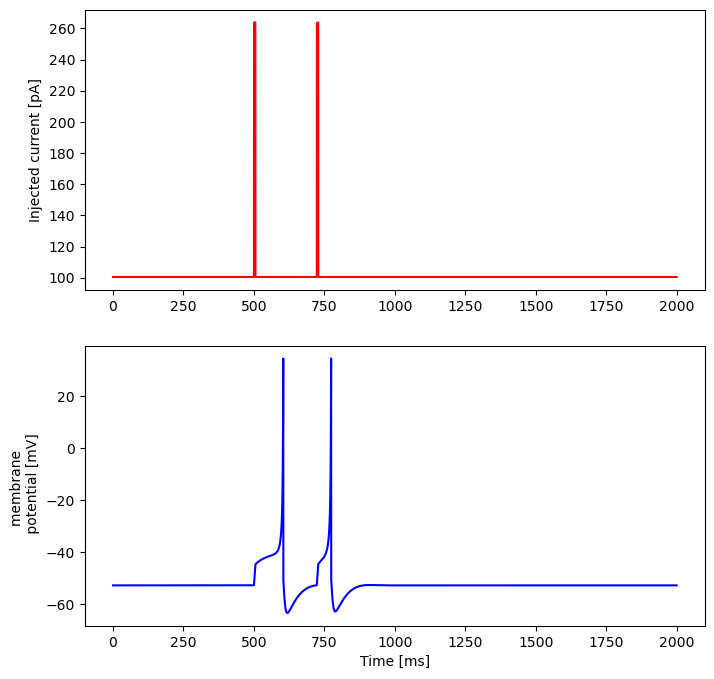

ISI: [223.02631052]
Frequency: [4.48377592]


In [ ]:
idx = 180

fig, ax = plot_potential_versus_injected(X[idx], T, I_inj[idx])
plt.show()
print(f"ISI: {ISI_range[idx]}")
print(f"Frequency: {1000/ISI_range[idx]}")

Bands
[276]
[158]
[[5.48095369 9.57395883]]


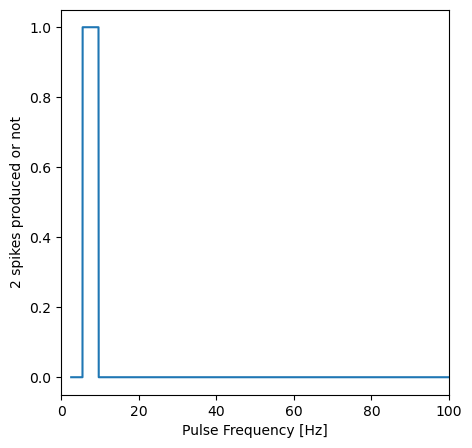

In [ ]:
# generate plot of number of spikes versus pulse frequency
# Need to account for the fact there is a spike latency
# end of first pulse is at 500 ms + 5 ms (= delay + pulse_duration)
# resonance frequency is then ISI_pulse - (pulse2_start - spike_time)


pulse2_start = np.zeros(N_neurons)      # store the start of the 2nd pulse for each simulation
spike_boolean = np.zeros(N_neurons)

for n in range(N_neurons):
    if len(spikes[n, np.isnan(spikes[n])]) != 1:
        spike_boolean[n] = 1

    pulse_times = np.argwhere(I_inj[n, :] >= threshold+1)*dt
    pulse2_start[n] = pulse_times[np.where(pulse_times > pulse1_end)][0] 


InterPulse_Intervals = pulse2_start - pulse1_end          # IPI for all sims

first_spike_time = pulse1_end + time_to_spike

resonant_ISI = pulse2_start - first_spike_time            # time between first spike and second pulse
resonant_f = 1000/resonant_ISI                            # corresponding resonance frequency

#print(resonant_f)
#print("- - - - - - -")
#print(spike_boolean)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(resonant_f, spike_boolean)
ax.set_xlabel("Pulse Frequency [Hz]")
ax.set_ylabel("2 spikes produced or not")
ax.set_xlim((0, 100))
freq_bands = get_resonance_bands(resonant_f, spike_boolean)
print(freq_bands)


#### Now test the multi-pulse protocol


In [ ]:
# first enduce a spike and find the height of the second spike which induces a 

pulse_frequency = np.mean(freq_bands, axis = 1)[0] # Hz
pulse_ISI = 1000/pulse_frequency # ms
pulse2_heights = np.linspace(100, 600, N_neurons)

# get the minimum height of the 2nd pulse.
pulse2_height = find_2nd_pulse_height(RS, pulse2_heights, threshold, x_ini, pulse_duration, pulse_height, time_to_spike, pulse_ISI) + 10
print(pulse2_height)

100%|██████████| 49999/49999 [00:15<00:00, 3210.59it/s]


[301.98664441]


In [ ]:
## Now use this 2nd pulse height as the standard height for the multipulse train.
# will just apply a fixed number of pulses, see if the pulse after a spike
# also produces a spike. Or rewrite classes to have an exit clause.
multipulse_ISIs = np.linspace(5, 200, N_neurons)
multipulse_freq = 1000/multipulse_ISIs
N_pulses = 10
pulse_duration = 5  # ms
delay = 30         # ms
I_multi = np.array([spikes_constant(N_iter, dt, threshold, isi, N_pulses, pulse2_height, pulse_duration, delay) for isi in multipulse_ISIs])
print(np.shape(I_multi))
# re-initialise the neuron batch
batch.Initialise(x_start, t_start)

(600, 200000)


In [ ]:
# run the multipulse tests
X, T, spikes = batch.update_batch(dt, N_iter, I_multi)


100%|██████████| 199999/199999 [01:02<00:00, 3204.61it/s]


In [ ]:
# Define pulse starts from the multipulse_ISIs
pulse_starts = np.array([[delay + i*(isi) for i in range(N_pulses)] for isi in multipulse_ISIs])
# pulse ends
pulse_ends = np.array([[delay + pulse_duration + i*(isi) for i in range(N_pulses)] for isi in multipulse_ISIs])


In [ ]:
## Testing extracting the pulse times


In [ ]:
spike_ISI = np.diff(spikes, axis = 1)
spike_freq = 1000/np.nanmean(spike_ISI, axis = 1)
spike_freq = np.nan_to_num(spike_freq, nan = 0.0)

num_spikes = np.zeros(N_neurons, dtype = int)

for i in range(N_neurons):
    print(spikes[i])
    print(spikes[i, ~np.isnan(spikes[i])])
    num_spikes[i] = len(spikes[i, ~np.isnan(spikes[i])])


print(num_spikes)

[40.29 53.62 73.63   nan   nan   nan   nan   nan   nan   nan]
[40.29 53.62 73.63]
[40.54 54.68 77.03   nan   nan   nan   nan   nan   nan   nan]
[40.54 54.68 77.03]
[40.77 56.38 81.15   nan   nan   nan   nan   nan   nan   nan]
[40.77 56.38 81.15]
[40.99 58.1  85.35   nan   nan   nan   nan   nan   nan   nan]
[40.99 58.1  85.35]
[41.21 59.74 89.54   nan   nan   nan   nan   nan   nan   nan]
[41.21 59.74 89.54]
[41.43 61.34 93.53   nan   nan   nan   nan   nan   nan   nan]
[41.43 61.34 93.53]
[41.64 63.   97.19   nan   nan   nan   nan   nan   nan   nan]
[41.64 63.   97.19]
[ 41.85  64.67 100.49    nan    nan    nan    nan    nan    nan    nan]
[ 41.85  64.67 100.49]
[ 42.05  66.4  103.91    nan    nan    nan    nan    nan    nan    nan]
[ 42.05  66.4  103.91]
[ 42.25  68.13 107.2     nan    nan    nan    nan    nan    nan    nan]
[ 42.25  68.13 107.2 ]
[ 42.44  69.9  110.57    nan    nan    nan    nan    nan    nan    nan]
[ 42.44  69.9  110.57]
[ 42.63  71.72 113.95    nan    nan    nan    

Number of pulses: 10
Pulse Frequency: 14.26
Number of spikes: 8
Firing Frequency: 10.94947598937153


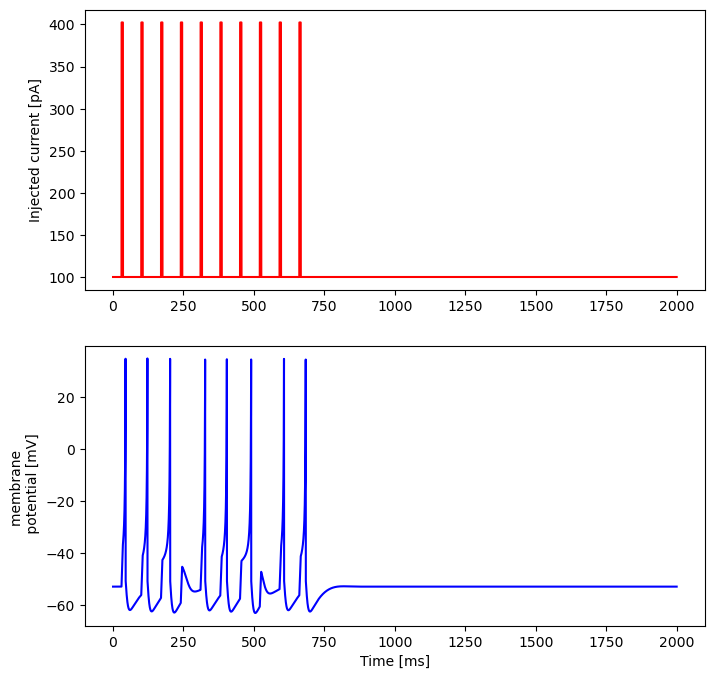

In [ ]:
idx = 200
print(f"Number of pulses: {N_pulses}")
print(f"Pulse Frequency: {np.round(multipulse_freq[idx], 2)}")
print(f"Number of spikes: {num_spikes[idx]}")
print(f"Firing Frequency: {spike_freq[idx]}")

fig, ax = plot_potential_versus_injected(X[idx, :], T, I_multi[idx, :])# , split)

plt.show()

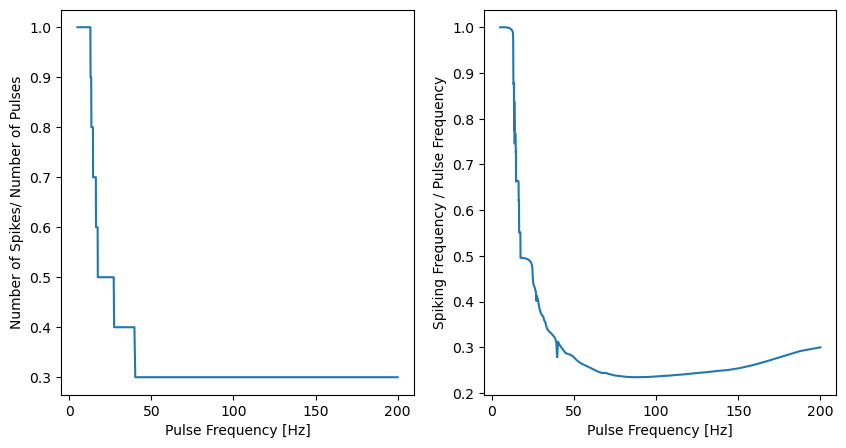

In [ ]:
freq_ratio = spike_freq/multipulse_freq
spike_ratio = num_spikes/N_pulses

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(multipulse_freq, spike_ratio)
ax[0].set(ylabel = "Number of Spikes/ Number of Pulses", xlabel = "Pulse Frequency [Hz]")
xmin = np.min(pulse_frequency)
xmax = np.max(pulse_frequency)
ax[0].hlines(y = 1, xmin = xmin, xmax = xmax, colors = "gray", linestyle = 'dashed')
#ax[0].set_xscale('log')

ax[1].plot(multipulse_freq, freq_ratio)
ax[1].hlines(y = 1, xmin = xmin, xmax = xmax, colors = "gray", linestyle = 'dashed')
#ax[1].set_xscale('log')
ax[1].set(ylabel = "Spiking Frequency / Pulse Frequency", xlabel = "Pulse Frequency [Hz]")

plt.show()

In [ ]:
### Testing with spike and pulse times.
print(np.shape(pulse_times))
pulse_start = pulse_times[np.where(np.diff(pulse_times, axis = 1) > dt)]
print(pulse_start)

(1000, 1)
[]


#### TEST HAZEM'S PROTOCOL


In [2]:
def simulated_current(N_iter, dt, threshold, pulse_height, first_IPI, pulse_duration, delay):
    
    I = threshold * np.ones(N_iter)

    # first pulse
    pulse1_start = int(delay/dt)
    pulse1_end = pulse1_start + int(pulse_duration[0]/dt)
    I[pulse1_start:pulse1_end] += pulse_height

    # second pulse
    pulse2_start = pulse1_end + int(first_IPI/dt)
    pulse2_end = pulse2_start + int(pulse_duration[1]/dt)
    I[pulse2_start:pulse2_end] += pulse_height

    return I
    



In [3]:
# param
RS = {'name': 'RS_resonator', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': 5, 'c': -50, 'd': 100, 'e': 0.0, 'f': 0.0, 'tau': 0.0}    # Class 1

f_vals = np.arange(-250, 251, 50)
idx_0 = np.argwhere(f_vals == 0)
f_vals = f_vals[np.r_[0:idx_0, idx_0+1:len(f_vals)]]
e_vals = np.arange(0.1, 0.5, 0.1)
tau_vals = np.array([0, 0.5, 2, 4])

params = []
params.append(RS)
for f in f_vals:
    for e in e_vals:
        for tau in tau_vals:
            temp_dict = RS.copy()
            temp_dict['f'] = f
            temp_dict['e'] = e
            temp_dict['tau'] = tau
            params.append(temp_dict)

print(np.shape(params))
params_df = pd.DataFrame(params)
print(params_df.head())

N_neurons = len(params_df)

T = 0.3
dt = 0.01
N_iter = int(1000*T/dt)


threshold, x_ini = find_threshold(params[0], np.linspace(50, 400, 50), T, dt)
print(threshold)

t_ini = 0.

x_start = np.full(shape=(N_neurons, 3), fill_value = x_ini)
t_start = np.zeros(N_neurons)



(161,)
           name    C    k  v_r  v_t  v_peak     a  b   c    d    e      f  tau
0  RS_resonator  100  0.7  -60  -40      35  0.03  5 -50  100  0.0    0.0  0.0
1  RS_resonator  100  0.7  -60  -40      35  0.03  5 -50  100  0.1 -250.0  0.0
2  RS_resonator  100  0.7  -60  -40      35  0.03  5 -50  100  0.1 -250.0  0.5
3  RS_resonator  100  0.7  -60  -40      35  0.03  5 -50  100  0.1 -250.0  2.0
4  RS_resonator  100  0.7  -60  -40      35  0.03  5 -50  100  0.1 -250.0  4.0


100%|██████████| 29999/29999 [00:05<00:00, 5221.28it/s]

[100.43731778]


In [5]:
# Initialise neuron
batch = batchAQUA(params_df)
batch.Initialise(x_start, t_start)

print(f"Net currents: {batch.get_net_autapse_currents()}")
print(f"Mean delay: {batch.get_mean_autapse_delays()}")

Net currents: [           nan -2500.         -2500.         -2500.
 -2500.         -1250.         -1250.         -1250.
 -1250.          -833.33333333  -833.33333333  -833.33333333
  -833.33333333  -625.          -625.          -625.
  -625.         -2000.         -2000.         -2000.
 -2000.         -1000.         -1000.         -1000.
 -1000.          -666.66666667  -666.66666667  -666.66666667
  -666.66666667  -500.          -500.          -500.
  -500.         -1500.         -1500.         -1500.
 -1500.          -750.          -750.          -750.
  -750.          -500.          -500.          -500.
  -500.          -375.          -375.          -375.
  -375.         -1000.         -1000.         -1000.
 -1000.          -500.          -500.          -500.
  -500.          -333.33333333  -333.33333333  -333.33333333
  -333.33333333  -250.          -250.          -250.
  -250.          -500.          -500.          -500.
  -500.          -250.          -250.          -250.
  -250. 

In [6]:
# Set up current 
delay = 100 # ms
pulse_duration = [45, 5]  # ms
first_IPI = 5   #  ms

# minimum pulse height and the time between the end of the pulse and the spike.
pulse_height, pulse_height2, time_to_spike = find_pulse_height(params[0], np.linspace(100, 1000, 100), threshold, x_ini, pulse_duration[1])  # pA
#pulse_height -= 10
#pulse_height2 = pulse_height - 2

test_pulse_height = 1 * pulse_height


I = np.array([simulated_current(N_iter, dt, threshold, test_pulse_height, first_IPI, pulse_duration, delay) for _ in range(len(params_df))])

100%|██████████| 49999/49999 [00:09<00:00, 5303.04it/s]


100%|██████████| 29999/29999 [00:06<00:00, 4836.55it/s]


{'name': np.str_('RS_resonator'), 'k': np.float64(0.7), 'C': np.float64(100.0), 'v_r': np.float64(-60.0), 'v_t': np.float64(-40.0), 'v_peak': np.float64(35.0), 'a': np.float64(0.03), 'b': np.float64(5.0), 'c': np.float64(-50.0), 'd': np.float64(100.0), 'e': np.float64(0.0), 'f': np.float64(0.0), 'tau': np.float64(0.0)}


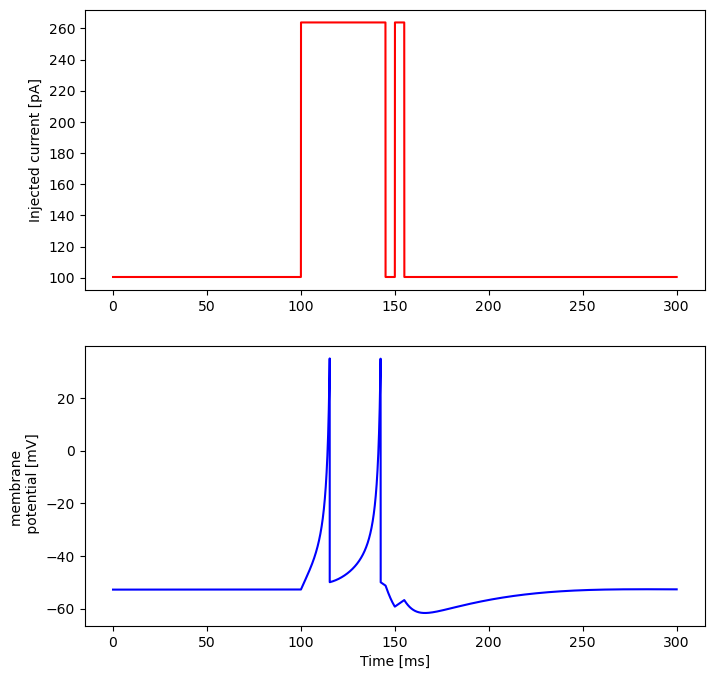

In [7]:
X, T, spikes = batch.update_batch(dt, N_iter, I)

print(batch.get_params(0))
fig, ax = plot_potential_versus_injected(X[0, :, :], T[:], I[0, :])
plt.show()

{'name': np.str_('RS_resonator'), 'k': np.float64(0.7), 'C': np.float64(100.0), 'v_r': np.float64(-60.0), 'v_t': np.float64(-40.0), 'v_peak': np.float64(35.0), 'a': np.float64(0.03), 'b': np.float64(5.0), 'c': np.float64(-50.0), 'd': np.float64(100.0), 'e': np.float64(0.1), 'f': np.float64(-250.0), 'tau': np.float64(0.0)}


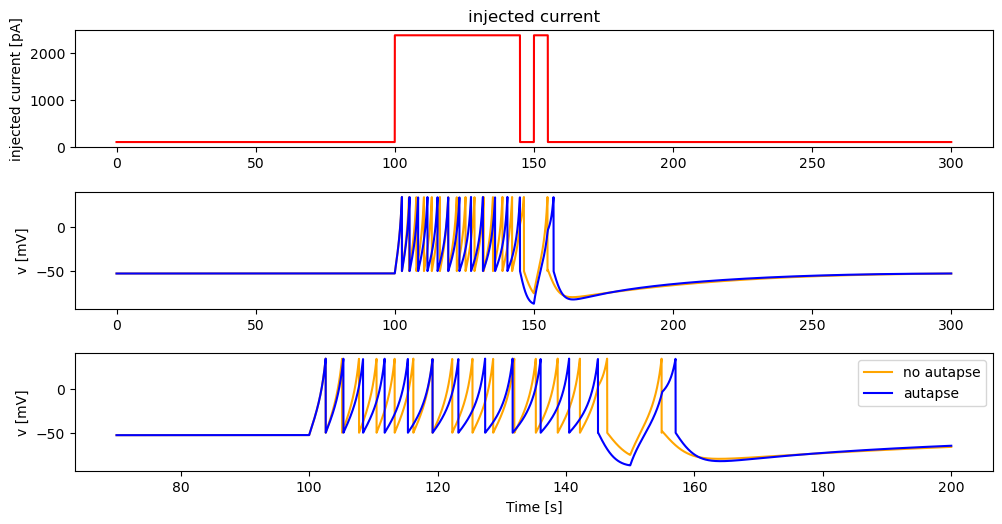

In [24]:
# plot both neurons together
print(batch.get_params(1))
fig, ax = compare_trains(X[0, 0, :], X[1, 0, :], T[:], I[0, :], indices = np.arange(int(70/dt), int(200/dt)))
plt.show()

{'name': np.str_('RS_resonator'), 'k': np.float64(0.7), 'C': np.float64(100.0), 'v_r': np.float64(-60.0), 'v_t': np.float64(-40.0), 'v_peak': np.float64(35.0), 'a': np.float64(0.03), 'b': np.float64(5.0), 'c': np.float64(-50.0), 'd': np.float64(100.0), 'e': np.float64(0.2), 'f': np.float64(250.0), 'tau': np.float64(2.0)}


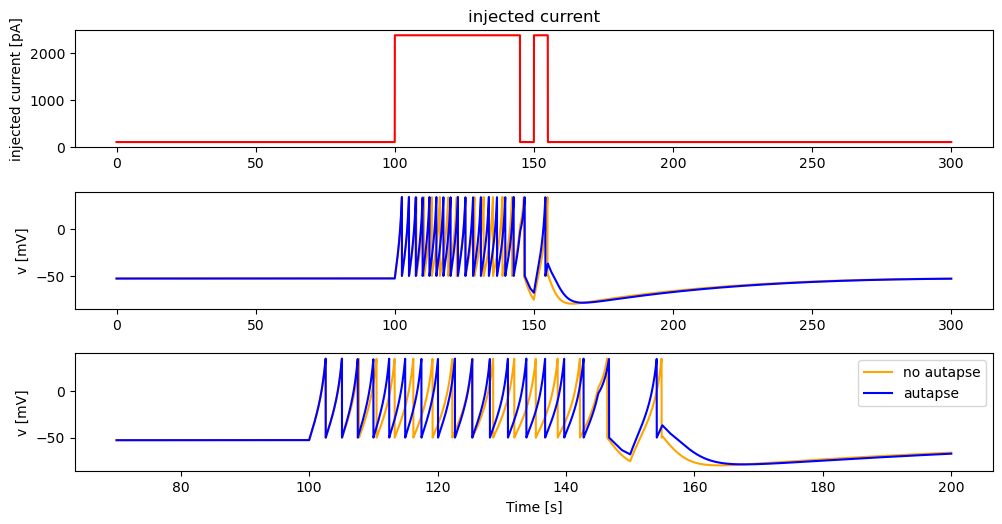

In [27]:
# plot both neurons together
idx = -10
print(batch.get_params(idx))
fig, ax = compare_trains(X[0, 0, :], X[idx, 0, :], T[:], I[0, :], indices = np.arange(int(70/dt), int(200/dt)))
plt.show()

[102.58 105.13 107.77 110.5  113.32 116.23 119.22 122.29 125.44 128.66
 131.95 135.3  138.71 142.17 146.41 154.89]
[102.58 105.34 108.4  111.76 115.38 119.22 123.24 127.41 131.69 136.05
 140.49 144.98 157.06]
[102.58 105.29 108.31 111.63 115.22 119.04 123.04 127.19 131.45 135.8
 140.22 144.7  157.09]
[102.58 105.15 108.05 111.27 114.79 118.55 122.51 126.62 130.84 135.15
 139.52 143.95 157.19]
[102.58 105.13 107.84 110.91 114.35 118.11 122.13 126.34 130.64 135.01
 139.44 143.92 158.93]
[102.58 105.32 108.29 111.45 114.76 118.2  121.74 125.38 129.1  132.9
 136.77 140.7  144.68 155.23]
[102.58 105.27 108.21 111.35 114.64 118.06 121.59 125.21 128.92 132.7
 136.55 140.46 144.43 155.2 ]
[102.58 105.15 108.01 111.1  114.36 117.75 121.25 124.84 128.51 132.26
 136.07 139.94 143.86 155.14]
[102.58 105.13 107.84 110.85 114.1  117.52 121.06 124.7  128.43 132.24
 136.11 140.05 144.04 155.65]
[102.58 105.3  108.21 111.26 114.43 117.7  121.07 124.52 128.06 131.67
 135.35 139.09 142.89 153.66]
[102.58

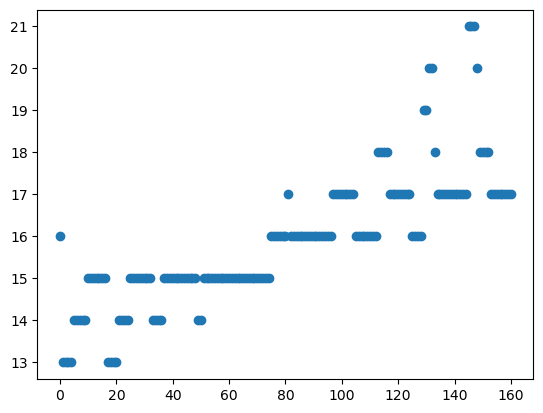

In [22]:
## All neurons spike at the short pulse!
num_spikes = np.zeros(len(spikes))
for i in range(len(spikes)):
    print(spikes[i][~np.isnan(spikes[i])])
    num_spikes[i] = len(spikes[i][~np.isnan(spikes[i])])

plt.scatter(np.arange(0, N_neurons), num_spikes)

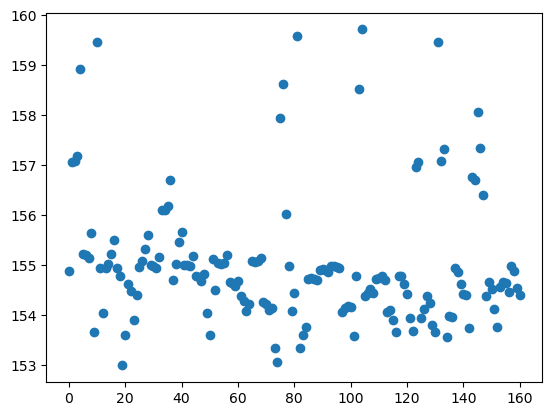

In [23]:
## What's the variation in the timing of the last spike
last_spike = np.zeros(len(spikes))
for i in range(len(spikes)):
    last_spike[i] = spikes[i][~np.isnan(spikes[i])][-1]

plt.scatter(np.arange(0, N_neurons), last_spike)